# Error modeling

The matching operation in this workbook takes a long time to run. You can run these cells later but please don't run them now since they will take hours to run.

We will run two experiments for error modeling.

1. Bypass experiment
2. Dextran pulse experiment

We will see how to setup a basic error model and how to carry the error from the bypass experiment over to the dextran pulse experiment.

## Standard imports

In [1]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

#Python path library support
from pathlib import Path

#python numeric library
import numpy

#python math library
import math

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#addict is a library that makes it easier to create nested dictionaries
from addict import Dict

#json is a standard text based format and it used in CADETMatch for the configuration file
import json

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

#jupyter widget support
from ipywidgets import interact
import ipywidgets as widgets

from CADETMatch.jupyter import Match

#This is just a support function to make running the examples a bit easier later
def deleteResultDir(path):
    #This is to try and make sure that only an actual result directory can be removed
    #And only if no other files have been added to the directory, just in case
    if not path.exists():
        return
    allowed = {'evo', 'grad', 'log', 'mcmc', 'meta', 'misc', 'progress', 
               'space', 'error.csv', 'result.h5', 'progress.csv'}
    allowed.add(match.csv)
    allowed.add(match_file.name)
    okayToRemove = False
    for child in path.iterdir():
        if child.name not in allowed:
            break
    else:
        okayToRemove = True
    if okayToRemove:
        import shutil
        shutil.rmtree(path)
        
def run_match(match_obj, match_file, true_values, delete):
    "create the matching object, run it and then look at output"
    match = Match(match_file.as_posix())

    resultDir = Path(match_obj.baseDir) / match_obj.resultsDir
    print("Your results are located at", resultDir.as_posix(), '\n\n')

    #If you want to delete the fitting process to start over remove the # from the next line and re-run this cell\
    if delete:
        deleteResultDir(resultDir)

    match.start_sim()

    match.plot_best()
    best ,score, best_score = match.get_best()
    for key,value in best_score.items():
        print("Method: %s" % key)
        for name, val, true_value in zip(match.cache.parameter_headers, value, true_values):
            print("%s = %.2e  true_value = %.2e error: %.2g%%" % (name, val, true_value, numpy.abs(val-true_value)/val*100))
        print('\n')
    return match

## Setup CADET path

In order to run examples we need to specify where CADET is.

On Windows just change the cadet_bin_path to the bin directory of CADET

On Linux you need to change the cadet_bin_path and also change cadet-cli.exe to cadet-cli on the following line.

In [2]:
#put in the path to the bin folder
cadet_bin_path = Path(r"C:\Users\kosh_000\cadet_build\CADET\VCPKG\bin")

cadet_path = cadet_bin_path / "cadet-cli.exe"

if cadet_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
else:
    print('CADET could not be found. Please check the bin path')
    
print(cadet_path.as_posix())

CADET was found. Continue to the next step.
C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe


## Create lesson folders and create lesson variables

This will create all the lesson folders we need and make it easier to refer to previous lessons

In [3]:
#set this to a directory on your computer where the cadet tutorial files can be saved
cadet_tutorial = Path('F:/temp/cadet_tutorial')
lesson_1 = cadet_tutorial / "lesson_1"
lesson_2 = cadet_tutorial / "lesson_2"
lesson_3 = cadet_tutorial / "lesson_3"
lesson_4 = cadet_tutorial / "lesson_4"
lesson_5 = cadet_tutorial / "lesson_5"
lesson_6 = cadet_tutorial / "lesson_6"
lesson_7 = cadet_tutorial / "lesson_7"
lesson_7.mkdir(exist_ok = True, parents=True)

# Create Bypass experiment

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_7/bypass/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


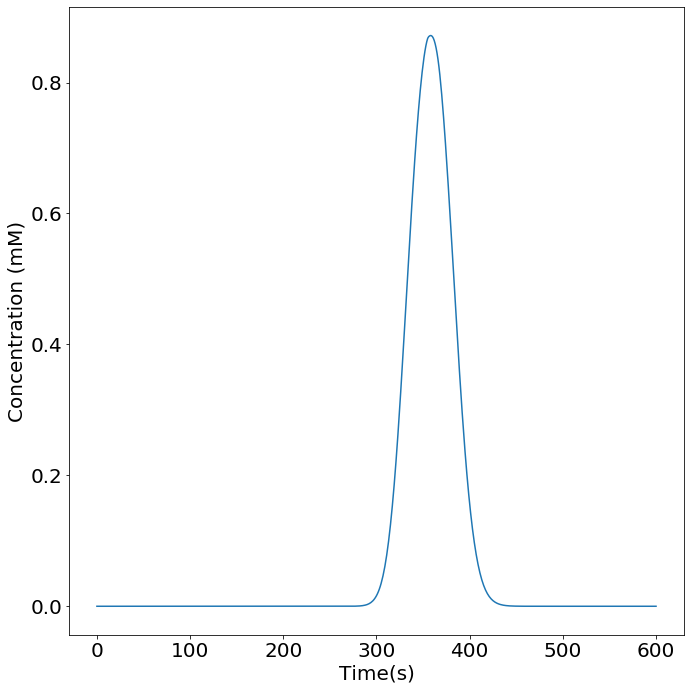

In [9]:
simple_example = lesson_1 / "simple_example"

bypass = lesson_7 / "bypass"
bypass.mkdir(exist_ok = True, parents=True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (simple_example / 'example.h5').as_posix()

simple.load()

simple.filename = (bypass / 'example.h5').as_posix()

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(simple.root.output.solution.solution_times,
        simple.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([simple.root.output.solution.solution_times,
                        simple.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((bypass / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file

In [7]:
match = Dict()
match.CADETPath = cadet_path.as_posix()
match.baseDir = bypass.as_posix()
match.resultsDir = 'fit_mcmc'
match.csv = 'fit_results.csv'
match.checkpointFile = "check"
match.stopAverage = 1
match.stopBest = 1
match.gradCheck = 1
match.gradVector = 1
match.searchMethod = 'NSGA3'
match.mutationRate = 1.0
match.crossoverRate = 1.0
match.generations = 1000
match.population = 12
match.minPopulation = 12
match.maxPopulation = 12
match.finalGradRefinement = 0
match.stallGenerations = 10
match.continueMCMC = 1


error_model = Dict()
error_model.file_path = "example.h5"
error_model.experimental_csv = "example.csv"
error_model.name = "main"
error_model.units = [2,]
error_model.delay = [0.0, 3.0]
error_model.flow = [1.0, 0.03]
error_model.load = [1.0, 0.03]
error_model.error_slope = [1.0, 0.001]
error_model.error_base = 50.0
error_model.base = 50.0
error_model.count = 100

match.kde_synthetic = [error_model,]

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.1
parameter2.max = 0.9

match.parameters = [parameter1, parameter2,]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

match.experiments = [experiment1,]

match_file = bypass / 'example_bypass.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Run match

Your results are located at F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc 


[2019-10-10 22:01:15,560] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-10 22:01:15,560] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-10 22:01:15,560] launcher  INFO    Worker distribution: 

[2019-10-10 22:01:15,560] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-10 22:01:18,551] util      (b'127.0.0.1:58801') INFO    example.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:01:18,680] match     (b'127.0.0.1:58801') INFO    simulation took 0.1279921531677246

[2019-10-10 22:01:18,693] match     (b'127.0.0.1:58801') INFO    create bias template for experiment main

[2019-10-10 22:01:19,107] gradFD    (b'127.0.0.1:58801') INFO    grad simulation took 0.3659992218017578

[2019-10-10 22:01:19,107] gradFD    (b'127.0.0.1:58801') INFO    grad F:/temp/cadet_tutori

[2019-10-10 22:01:49,973] util      (b'127.0.0.1:58801') INFO    Generation: 37 	Population: 24 	Average Score: 0.996 	Best: 1 	Minimum Score: 0.992 	Best: 1 	Product Score: 0.996 	Best: 1

[2019-10-10 22:01:54,368] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-10 22:01:54,368] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-10 22:01:54,368] launcher  INFO    Worker distribution: 

[2019-10-10 22:01:54,368] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-10 22:01:56,365] generate_corner_graphs (b'127.0.0.1:55640') INFO    graphing directory F:\temp\cadet_tutorial\lesson_7\bypass

[2019-10-10 22:01:56,365] generate_corner_graphs (b'127.0.0.1:55640') INFO    plotting corner plots

[2019-10-10 22:01:56,369] generate_corner_graphs (b'127.0.0.1:55640') INFO    graphing remove 0 points

[2019-10-10 22:02:10,628] launcher  (127.0.0.1:57702) INFO   


[2019-10-10 22:02:11,825] util      (b'127.0.0.1:63459') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:11,825] util      (b'127.0.0.1:58039') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:11,876] util      (b'127.0.0.1:60284') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:11,888] util      (b'127.0.0.1:54515') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:11,891] util      (b'127.0.0.1:61968') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:11,892] util      (b'127.0.0.1:52235') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol

[2019-10-10 22:02:13,306] util      (b'127.0.0.1:57161') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:13,375] util      (b'127.0.0.1:58039') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:13,381] util      (b'127.0.0.1:63459') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:13,385] util      (b'127.0.0.1:52235') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:13,421] util      (b'127.0.0.1:58801') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-10 22:02:13,428] util      (b'127.0.0.1:61357') INFO    F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc/misc/best_main_base.h5 abstol=4.71e-05  reltol=

[2019-10-10 22:02:48,069] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 25 accept: 0.617 std: 0.0293 mean: 0.591 converge: 58.6

[2019-10-10 22:02:48,850] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 26 accept: 0.606 std: 0.0289 mean: 0.592 converge: 57.8

[2019-10-10 22:02:49,728] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 27 accept: 0.607 std: 0.0285 mean: 0.592 converge: 57.1

[2019-10-10 22:02:50,606] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 28 accept: 0.611 std: 0.0282 mean: 0.593 converge: 56.5

[2019-10-10 22:02:51,362] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 29 accept: 0.607 std: 0.0279 mean: 0.593 converge: 55.8

[2019-10-10 22:02:52,312] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 30 accept: 0.613 std: 0.0276 mean: 0.594 converge: 55.3

[2019-10-10 22:02:53,206] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 31 accept: 0.615 std: 0.0274 mean: 0.595 converge: 54.9

[2019-10-10 22:02:53,946] mcmc      (b'127.0.0.1:58801') INFO 

[2019-10-10 22:03:39,636] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 87 accept: 0.634 std: 0.0101 mean: 0.619 converge: 20.3

[2019-10-10 22:03:40,489] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 88 accept: 0.633 std: 0.0102 mean: 0.62 converge: 20.5

[2019-10-10 22:03:41,239] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 89 accept: 0.633 std: 0.0104 mean: 0.62 converge: 20.8

[2019-10-10 22:03:42,083] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 90 accept: 0.633 std: 0.0105 mean: 0.62 converge: 21

[2019-10-10 22:03:42,819] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 91 accept: 0.634 std: 0.0107 mean: 0.621 converge: 21.4

[2019-10-10 22:03:43,568] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 92 accept: 0.633 std: 0.0108 mean: 0.621 converge: 21.6

[2019-10-10 22:03:44,428] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 93 accept: 0.633 std: 0.0109 mean: 0.621 converge: 21.7

[2019-10-10 22:03:45,314] mcmc      (b'127.0.0.1:58801') INFO    bu

[2019-10-10 22:04:32,233] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 148 accept: 0.618 std: 0.00425 mean: 0.625 converge: 8.5

[2019-10-10 22:04:33,140] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 149 accept: 0.618 std: 0.0042 mean: 0.624 converge: 8.41

[2019-10-10 22:04:34,003] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 150 accept: 0.618 std: 0.00412 mean: 0.624 converge: 8.25

[2019-10-10 22:04:34,870] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 151 accept: 0.618 std: 0.00398 mean: 0.624 converge: 7.95

[2019-10-10 22:04:35,637] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 152 accept: 0.618 std: 0.00378 mean: 0.623 converge: 7.57

[2019-10-10 22:04:36,627] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 153 accept: 0.618 std: 0.00365 mean: 0.623 converge: 7.29

[2019-10-10 22:04:37,610] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 154 accept: 0.617 std: 0.00358 mean: 0.623 converge: 7.17

[2019-10-10 22:04:38,527] mcmc      (b'127.0.0.1:5

[2019-10-10 22:05:25,063] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 209 accept: 0.608 std: 0.0017 mean: 0.61 converge: 3.4

[2019-10-10 22:05:25,943] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 210 accept: 0.608 std: 0.00147 mean: 0.61 converge: 2.95

[2019-10-10 22:05:26,707] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 211 accept: 0.608 std: 0.0013 mean: 0.61 converge: 2.61

[2019-10-10 22:05:27,579] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 212 accept: 0.607 std: 0.00118 mean: 0.61 converge: 2.36

[2019-10-10 22:05:28,637] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 213 accept: 0.607 std: 0.00115 mean: 0.61 converge: 2.3

[2019-10-10 22:05:29,515] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 214 accept: 0.607 std: 0.00114 mean: 0.609 converge: 2.29

[2019-10-10 22:05:30,379] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 215 accept: 0.607 std: 0.00118 mean: 0.609 converge: 2.35

[2019-10-10 22:05:31,173] mcmc      (b'127.0.0.1:58801') 

[2019-10-10 22:06:16,979] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 270 accept: 0.606 std: 0.000734 mean: 0.606 converge: 1.47

[2019-10-10 22:06:17,743] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 271 accept: 0.606 std: 0.000738 mean: 0.606 converge: 1.48

[2019-10-10 22:06:18,631] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 272 accept: 0.606 std: 0.000739 mean: 0.606 converge: 1.48

[2019-10-10 22:06:19,381] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 273 accept: 0.607 std: 0.000752 mean: 0.606 converge: 1.5

[2019-10-10 22:06:20,262] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 274 accept: 0.607 std: 0.000777 mean: 0.606 converge: 1.55

[2019-10-10 22:06:21,128] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 275 accept: 0.607 std: 0.000791 mean: 0.606 converge: 1.58

[2019-10-10 22:06:21,995] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 276 accept: 0.607 std: 0.000819 mean: 0.606 converge: 1.64

[2019-10-10 22:06:22,795] mcmc      (b'127

[2019-10-10 22:07:08,934] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 331 accept: 0.612 std: 0.00133 mean: 0.611 converge: 2.65

[2019-10-10 22:07:10,020] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 332 accept: 0.612 std: 0.00129 mean: 0.611 converge: 2.59

[2019-10-10 22:07:11,095] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 333 accept: 0.612 std: 0.00127 mean: 0.611 converge: 2.53

[2019-10-10 22:07:12,067] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 334 accept: 0.613 std: 0.00122 mean: 0.611 converge: 2.44

[2019-10-10 22:07:13,106] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 335 accept: 0.612 std: 0.00114 mean: 0.611 converge: 2.29

[2019-10-10 22:07:14,047] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 336 accept: 0.612 std: 0.00108 mean: 0.611 converge: 2.16

[2019-10-10 22:07:15,040] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 337 accept: 0.613 std: 0.00103 mean: 0.612 converge: 2.06

[2019-10-10 22:07:16,099] mcmc      (b'127.0.0.1

[2019-10-10 22:08:05,823] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 390 accept: 0.463 std: 0.012 mean: 0.466 converge: 24

[2019-10-10 22:08:06,801] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 391 accept: 0.467 std: 0.0119 mean: 0.466 converge: 23.7

[2019-10-10 22:08:07,652] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 392 accept: 0.469 std: 0.0117 mean: 0.466 converge: 23.4

[2019-10-10 22:08:08,652] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 393 accept: 0.468 std: 0.0116 mean: 0.466 converge: 23.2

[2019-10-10 22:08:09,551] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 394 accept: 0.47 std: 0.0114 mean: 0.466 converge: 22.9

[2019-10-10 22:08:10,633] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 395 accept: 0.468 std: 0.0113 mean: 0.466 converge: 22.6

[2019-10-10 22:08:11,538] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 396 accept: 0.469 std: 0.0112 mean: 0.466 converge: 22.4

[2019-10-10 22:08:12,412] mcmc      (b'127.0.0.1:58801') IN

[2019-10-10 22:09:00,451] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 451 accept: 0.482 std: 0.00179 mean: 0.478 converge: 3.58

[2019-10-10 22:09:01,364] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 452 accept: 0.482 std: 0.00186 mean: 0.478 converge: 3.72

[2019-10-10 22:09:02,173] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 453 accept: 0.479 std: 0.00186 mean: 0.478 converge: 3.73

[2019-10-10 22:09:03,072] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 454 accept: 0.481 std: 0.00184 mean: 0.478 converge: 3.68

[2019-10-10 22:09:04,007] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 455 accept: 0.482 std: 0.00184 mean: 0.478 converge: 3.68

[2019-10-10 22:09:04,915] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 456 accept: 0.481 std: 0.00177 mean: 0.479 converge: 3.54

[2019-10-10 22:09:05,724] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 457 accept: 0.482 std: 0.00176 mean: 0.479 converge: 3.51

[2019-10-10 22:09:06,635] mcmc      (b'127.0.0.1

[2019-10-10 22:09:53,905] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 512 accept: 0.486 std: 0.00191 mean: 0.483 converge: 3.83

[2019-10-10 22:09:54,807] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 513 accept: 0.487 std: 0.00198 mean: 0.483 converge: 3.96

[2019-10-10 22:09:55,721] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 514 accept: 0.488 std: 0.00206 mean: 0.483 converge: 4.12

[2019-10-10 22:09:56,528] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 515 accept: 0.488 std: 0.00215 mean: 0.484 converge: 4.31

[2019-10-10 22:09:57,432] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 516 accept: 0.488 std: 0.00224 mean: 0.484 converge: 4.48

[2019-10-10 22:09:58,331] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 517 accept: 0.489 std: 0.00235 mean: 0.484 converge: 4.7

[2019-10-10 22:09:59,292] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 518 accept: 0.489 std: 0.00246 mean: 0.484 converge: 4.91

[2019-10-10 22:10:00,331] mcmc      (b'127.0.0.1:

[2019-10-10 22:10:48,198] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 573 accept: 0.484 std: 0.00237 mean: 0.486 converge: 4.74

[2019-10-10 22:10:49,209] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 574 accept: 0.484 std: 0.00235 mean: 0.486 converge: 4.71

[2019-10-10 22:10:50,172] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 575 accept: 0.485 std: 0.00231 mean: 0.486 converge: 4.63

[2019-10-10 22:10:51,061] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 576 accept: 0.486 std: 0.0023 mean: 0.486 converge: 4.6

[2019-10-10 22:10:51,916] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 577 accept: 0.486 std: 0.00229 mean: 0.486 converge: 4.57

[2019-10-10 22:10:52,864] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 578 accept: 0.486 std: 0.00228 mean: 0.485 converge: 4.55

[2019-10-10 22:10:53,843] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 579 accept: 0.486 std: 0.00226 mean: 0.485 converge: 4.52

[2019-10-10 22:10:54,942] mcmc      (b'127.0.0.1:5

[2019-10-10 22:11:46,160] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 634 accept: 0.491 std: 0.00301 mean: 0.489 converge: 6.02

[2019-10-10 22:11:47,006] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 635 accept: 0.491 std: 0.00293 mean: 0.489 converge: 5.87

[2019-10-10 22:11:48,007] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 636 accept: 0.491 std: 0.00287 mean: 0.489 converge: 5.75

[2019-10-10 22:11:48,924] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 637 accept: 0.49 std: 0.00279 mean: 0.489 converge: 5.59

[2019-10-10 22:11:49,814] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 638 accept: 0.49 std: 0.00271 mean: 0.49 converge: 5.42

[2019-10-10 22:11:50,849] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 639 accept: 0.49 std: 0.00263 mean: 0.49 converge: 5.26

[2019-10-10 22:11:51,896] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 640 accept: 0.49 std: 0.00256 mean: 0.49 converge: 5.11

[2019-10-10 22:11:52,794] mcmc      (b'127.0.0.1:58801'

[2019-10-10 22:12:44,668] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 695 accept: 0.484 std: 0.00113 mean: 0.486 converge: 2.26

[2019-10-10 22:12:45,512] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 696 accept: 0.484 std: 0.00113 mean: 0.486 converge: 2.25

[2019-10-10 22:12:46,422] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 697 accept: 0.484 std: 0.00113 mean: 0.485 converge: 2.25

[2019-10-10 22:12:47,372] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 698 accept: 0.483 std: 0.00113 mean: 0.485 converge: 2.26

[2019-10-10 22:12:48,344] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 699 accept: 0.483 std: 0.00112 mean: 0.485 converge: 2.25

[2019-10-10 22:12:49,311] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 700 accept: 0.483 std: 0.00111 mean: 0.485 converge: 2.22

[2019-10-10 22:12:50,181] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 701 accept: 0.484 std: 0.00107 mean: 0.485 converge: 2.14

[2019-10-10 22:12:51,044] mcmc      (b'127.0.0.1

[2019-10-10 22:13:36,277] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 754 accept: 0.385 std: 0.02 mean: 0.367 converge: 40

[2019-10-10 22:13:37,246] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 755 accept: 0.425 std: 0.0292 mean: 0.379 converge: 58.5

[2019-10-10 22:13:38,131] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 756 accept: 0.396 std: 0.0274 mean: 0.382 converge: 54.9

[2019-10-10 22:13:38,971] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 757 accept: 0.369 std: 0.0258 mean: 0.38 converge: 51.6

[2019-10-10 22:13:39,762] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 758 accept: 0.359 std: 0.025 mean: 0.377 converge: 50.1

[2019-10-10 22:13:40,600] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 759 accept: 0.352 std: 0.0249 mean: 0.374 converge: 49.8

[2019-10-10 22:13:41,506] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 760 accept: 0.35 std: 0.0248 mean: 0.372 converge: 49.5

[2019-10-10 22:13:42,354] mcmc      (b'127.0.0.1:58801') INFO 

[2019-10-10 22:14:30,450] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 815 accept: 0.358 std: 0.00636 mean: 0.36 converge: 12.7

[2019-10-10 22:14:31,492] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 816 accept: 0.358 std: 0.00637 mean: 0.36 converge: 12.7

[2019-10-10 22:14:32,365] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 817 accept: 0.359 std: 0.00621 mean: 0.36 converge: 12.4

[2019-10-10 22:14:33,270] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 818 accept: 0.358 std: 0.00617 mean: 0.36 converge: 12.3

[2019-10-10 22:14:34,327] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 819 accept: 0.357 std: 0.00615 mean: 0.36 converge: 12.3

[2019-10-10 22:14:35,208] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 820 accept: 0.357 std: 0.00616 mean: 0.36 converge: 12.3

[2019-10-10 22:14:36,089] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 821 accept: 0.356 std: 0.00603 mean: 0.359 converge: 12.1

[2019-10-10 22:14:37,113] mcmc      (b'127.0.0.1:58801

[2019-10-10 22:15:28,366] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 876 accept: 0.369 std: 0.00273 mean: 0.367 converge: 5.45

[2019-10-10 22:15:29,456] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 877 accept: 0.37 std: 0.00259 mean: 0.367 converge: 5.17

[2019-10-10 22:15:30,622] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 878 accept: 0.37 std: 0.00249 mean: 0.367 converge: 4.99

[2019-10-10 22:15:31,742] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 879 accept: 0.37 std: 0.00241 mean: 0.367 converge: 4.81

[2019-10-10 22:15:32,853] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 880 accept: 0.369 std: 0.00231 mean: 0.368 converge: 4.62

[2019-10-10 22:15:33,799] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 881 accept: 0.368 std: 0.00215 mean: 0.368 converge: 4.3

[2019-10-10 22:15:34,916] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 882 accept: 0.367 std: 0.00203 mean: 0.368 converge: 4.06

[2019-10-10 22:15:35,881] mcmc      (b'127.0.0.1:588

[2019-10-10 22:16:27,432] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 937 accept: 0.375 std: 0.00279 mean: 0.374 converge: 5.58

[2019-10-10 22:16:28,445] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 938 accept: 0.374 std: 0.00265 mean: 0.374 converge: 5.3

[2019-10-10 22:16:29,332] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 939 accept: 0.374 std: 0.00251 mean: 0.374 converge: 5.02

[2019-10-10 22:16:30,473] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 940 accept: 0.373 std: 0.00232 mean: 0.374 converge: 4.63

[2019-10-10 22:16:31,358] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 941 accept: 0.374 std: 0.00215 mean: 0.374 converge: 4.3

[2019-10-10 22:16:32,378] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 942 accept: 0.375 std: 0.00193 mean: 0.374 converge: 3.85

[2019-10-10 22:16:33,229] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 943 accept: 0.374 std: 0.00171 mean: 0.374 converge: 3.42

[2019-10-10 22:16:34,112] mcmc      (b'127.0.0.1:5

[2019-10-10 22:17:22,870] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 996 accept: 0.307 std: 0.0338 mean: 0.31 converge: 67.5

[2019-10-10 22:17:23,756] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 997 accept: 0.31 std: 0.0329 mean: 0.31 converge: 65.8

[2019-10-10 22:17:24,655] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 998 accept: 0.317 std: 0.0321 mean: 0.311 converge: 64.3

[2019-10-10 22:17:25,607] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 999 accept: 0.312 std: 0.0314 mean: 0.311 converge: 62.8

[2019-10-10 22:17:26,667] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1000 accept: 0.31 std: 0.0307 mean: 0.311 converge: 61.4

[2019-10-10 22:17:27,542] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1001 accept: 0.309 std: 0.0301 mean: 0.311 converge: 60.1

[2019-10-10 22:17:28,431] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1002 accept: 0.305 std: 0.0295 mean: 0.311 converge: 59

[2019-10-10 22:17:29,452] mcmc      (b'127.0.0.1:58801') I

[2019-10-10 22:18:19,911] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1057 accept: 0.292 std: 0.00324 mean: 0.286 converge: 6.49

[2019-10-10 22:18:20,938] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1058 accept: 0.291 std: 0.00331 mean: 0.287 converge: 6.62

[2019-10-10 22:18:21,916] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1059 accept: 0.291 std: 0.00332 mean: 0.287 converge: 6.65

[2019-10-10 22:18:22,917] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1060 accept: 0.292 std: 0.00332 mean: 0.287 converge: 6.65

[2019-10-10 22:18:23,814] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1061 accept: 0.291 std: 0.0033 mean: 0.287 converge: 6.6

[2019-10-10 22:18:24,862] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1062 accept: 0.291 std: 0.00335 mean: 0.287 converge: 6.69

[2019-10-10 22:18:25,744] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1063 accept: 0.293 std: 0.00344 mean: 0.287 converge: 6.89

[2019-10-10 22:18:26,740] mcmc      (b'127.

[2019-10-10 22:19:17,862] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1118 accept: 0.294 std: 0.00169 mean: 0.291 converge: 3.38

[2019-10-10 22:19:18,912] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1119 accept: 0.295 std: 0.00176 mean: 0.291 converge: 3.53

[2019-10-10 22:19:19,834] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1120 accept: 0.295 std: 0.00181 mean: 0.291 converge: 3.62

[2019-10-10 22:19:20,746] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1121 accept: 0.295 std: 0.00184 mean: 0.291 converge: 3.69

[2019-10-10 22:19:21,659] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1122 accept: 0.296 std: 0.00193 mean: 0.291 converge: 3.86

[2019-10-10 22:19:22,731] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1123 accept: 0.295 std: 0.002 mean: 0.291 converge: 4.01

[2019-10-10 22:19:23,768] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1124 accept: 0.296 std: 0.00213 mean: 0.291 converge: 4.26

[2019-10-10 22:19:24,770] mcmc      (b'127.

[2019-10-10 22:20:16,367] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1178 accept: 0.285 std: 0.00429 mean: 0.291 converge: 8.57

[2019-10-10 22:20:17,341] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1179 accept: 0.285 std: 0.00423 mean: 0.29 converge: 8.47

[2019-10-10 22:20:18,462] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1180 accept: 0.285 std: 0.00418 mean: 0.29 converge: 8.35

[2019-10-10 22:20:19,356] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1181 accept: 0.285 std: 0.00412 mean: 0.29 converge: 8.24

[2019-10-10 22:20:20,501] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1182 accept: 0.285 std: 0.00406 mean: 0.29 converge: 8.12

[2019-10-10 22:20:21,463] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1183 accept: 0.285 std: 0.004 mean: 0.289 converge: 8.01

[2019-10-10 22:20:22,531] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1184 accept: 0.284 std: 0.00393 mean: 0.289 converge: 7.87

[2019-10-10 22:20:23,544] mcmc      (b'127.0.0.

[2019-10-10 22:21:15,304] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1239 accept: 0.276 std: 0.00224 mean: 0.278 converge: 4.49

[2019-10-10 22:21:16,283] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1240 accept: 0.276 std: 0.00216 mean: 0.278 converge: 4.33

[2019-10-10 22:21:17,151] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1241 accept: 0.276 std: 0.00206 mean: 0.278 converge: 4.12

[2019-10-10 22:21:17,990] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1242 accept: 0.276 std: 0.00199 mean: 0.278 converge: 3.97

[2019-10-10 22:21:18,950] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1243 accept: 0.276 std: 0.00193 mean: 0.278 converge: 3.87

[2019-10-10 22:21:19,777] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1244 accept: 0.276 std: 0.00186 mean: 0.277 converge: 3.73

[2019-10-10 22:21:20,694] mcmc      (b'127.0.0.1:58801') INFO    burn:  idx: 1245 accept: 0.276 std: 0.00182 mean: 0.277 converge: 3.63

[2019-10-10 22:21:21,211] launcher  INFO 

[2019-10-10 22:22:13,670] generate_corner_graphs (b'127.0.0.1:52895') INFO    graphing directory F:\temp\cadet_tutorial\lesson_7\bypass

[2019-10-10 22:22:13,671] generate_corner_graphs (b'127.0.0.1:52895') INFO    plotting corner plots

[2019-10-10 22:22:13,677] generate_corner_graphs (b'127.0.0.1:52895') INFO    plot burn in acceptance

[2019-10-10 22:22:13,811] generate_corner_graphs (b'127.0.0.1:52895') INFO    plotting chain

[2019-10-10 22:22:14,588] generate_corner_graphs (b'127.0.0.1:52895') INFO    plotting mcmc param 0

[2019-10-10 22:22:14,734] generate_corner_graphs (b'127.0.0.1:52895') INFO    plotting mcmc param 0

[2019-10-10 22:22:14,881] generate_corner_graphs (b'127.0.0.1:52895') INFO    plotting mcmc param 1

[2019-10-10 22:22:15,024] generate_corner_graphs (b'127.0.0.1:52895') INFO    plotting mcmc param 1

[2019-10-10 22:22:15,688] launcher  (127.0.0.1:58125) INFO    Root process is done.

[2019-10-10 22:22:15,689] launcher  (127.0.0.1:58125) INFO    Finished clean

[2019-10-10 22:23:11,318] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 34 accept: 0.317

[2019-10-10 22:23:12,346] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 35 accept: 0.312

[2019-10-10 22:23:13,225] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 36 accept: 0.310

[2019-10-10 22:23:14,126] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 37 accept: 0.307

[2019-10-10 22:23:14,866] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 38 accept: 0.306

[2019-10-10 22:23:15,791] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 39 accept: 0.307

[2019-10-10 22:23:16,687] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 40 accept: 0.310

[2019-10-10 22:23:17,448] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 41 accept: 0.314

[2019-10-10 22:23:18,320] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 42 accept: 0.314

[2019-10-10 22:23:19,206] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 43 accept: 0.313

[2019-10-10 22:23:20,068] mcmc      (b'127.0.0.1:58801') INF

[2019-10-10 22:24:17,700] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 109 accept: 0.303

[2019-10-10 22:24:18,613] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 110 accept: 0.304

[2019-10-10 22:24:19,528] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 111 accept: 0.305

[2019-10-10 22:24:20,523] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 112 accept: 0.305

[2019-10-10 22:24:21,353] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 113 accept: 0.306

[2019-10-10 22:24:22,172] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 114 accept: 0.307

[2019-10-10 22:24:22,981] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 115 accept: 0.306

[2019-10-10 22:24:23,902] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 116 accept: 0.305

[2019-10-10 22:24:24,836] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 117 accept: 0.305

[2019-10-10 22:24:25,633] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 118 accept: 0.304

[2019-10-10 22:24:26,588] mcmc      (b'127.0.0.1:5

[2019-10-10 22:25:23,622] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 184 accept: 0.308

[2019-10-10 22:25:24,507] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 185 accept: 0.308

[2019-10-10 22:25:25,400] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 186 accept: 0.309

[2019-10-10 22:25:26,253] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 187 accept: 0.309

[2019-10-10 22:25:27,046] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 188 accept: 0.308

[2019-10-10 22:25:27,945] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 189 accept: 0.309

[2019-10-10 22:25:28,749] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 190 accept: 0.309

[2019-10-10 22:25:29,621] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 191 accept: 0.309

[2019-10-10 22:25:30,512] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 192 accept: 0.309

[2019-10-10 22:25:31,447] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 193 accept: 0.309

[2019-10-10 22:25:32,344] mcmc      (b'127.0.0.1:5

[2019-10-10 22:26:28,221] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 258 accept: 0.317

[2019-10-10 22:26:29,136] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 259 accept: 0.318

[2019-10-10 22:26:30,088] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 260 accept: 0.318

[2019-10-10 22:26:30,927] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 261 accept: 0.318

[2019-10-10 22:26:31,830] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 262 accept: 0.318

[2019-10-10 22:26:32,784] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 263 accept: 0.318

[2019-10-10 22:26:33,585] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 264 accept: 0.318

[2019-10-10 22:26:34,503] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 265 accept: 0.318

[2019-10-10 22:26:35,315] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 266 accept: 0.318

[2019-10-10 22:26:36,217] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 267 accept: 0.318

[2019-10-10 22:26:37,149] mcmc      (b'127.0.0.1:5

[2019-10-10 22:27:35,906] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 332 accept: 0.318

[2019-10-10 22:27:36,850] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 333 accept: 0.319

[2019-10-10 22:27:37,897] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 334 accept: 0.318

[2019-10-10 22:27:38,850] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 335 accept: 0.318

[2019-10-10 22:27:39,865] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 336 accept: 0.318

[2019-10-10 22:27:40,858] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 337 accept: 0.318

[2019-10-10 22:27:41,741] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 338 accept: 0.318

[2019-10-10 22:27:42,752] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 339 accept: 0.318

[2019-10-10 22:27:43,616] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 340 accept: 0.317

[2019-10-10 22:27:44,540] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 341 accept: 0.317

[2019-10-10 22:27:45,367] mcmc      (b'127.0.0.1:5

[2019-10-10 22:28:44,104] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 406 accept: 0.314

[2019-10-10 22:28:45,052] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 407 accept: 0.314

[2019-10-10 22:28:45,936] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 408 accept: 0.313

[2019-10-10 22:28:46,714] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 409 accept: 0.313

[2019-10-10 22:28:47,624] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 410 accept: 0.313

[2019-10-10 22:28:48,426] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 411 accept: 0.313

[2019-10-10 22:28:49,334] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 412 accept: 0.313

[2019-10-10 22:28:50,210] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 413 accept: 0.313

[2019-10-10 22:28:51,140] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 414 accept: 0.313

[2019-10-10 22:28:52,150] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 415 accept: 0.312

[2019-10-10 22:28:52,961] mcmc      (b'127.0.0.1:5

[2019-10-10 22:29:50,132] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 480 accept: 0.309

[2019-10-10 22:29:51,112] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 481 accept: 0.309

[2019-10-10 22:29:51,925] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 482 accept: 0.309

[2019-10-10 22:29:52,741] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 483 accept: 0.310

[2019-10-10 22:29:53,678] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 484 accept: 0.310

[2019-10-10 22:29:54,504] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 485 accept: 0.310

[2019-10-10 22:29:55,350] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 486 accept: 0.311

[2019-10-10 22:29:56,417] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 487 accept: 0.311

[2019-10-10 22:29:57,237] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 488 accept: 0.310

[2019-10-10 22:29:58,193] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 489 accept: 0.310

[2019-10-10 22:29:59,065] mcmc      (b'127.0.0.1:5

[2019-10-10 22:30:55,356] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 554 accept: 0.312

[2019-10-10 22:30:56,172] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 555 accept: 0.312

[2019-10-10 22:30:57,085] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 556 accept: 0.312

[2019-10-10 22:30:57,885] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 557 accept: 0.312

[2019-10-10 22:30:58,819] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 558 accept: 0.311

[2019-10-10 22:30:59,717] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 559 accept: 0.311

[2019-10-10 22:31:00,605] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 560 accept: 0.312

[2019-10-10 22:31:01,425] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 561 accept: 0.312

[2019-10-10 22:31:02,422] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 562 accept: 0.312

[2019-10-10 22:31:03,208] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 563 accept: 0.312

[2019-10-10 22:31:04,010] mcmc      (b'127.0.0.1:5

[2019-10-10 22:32:02,457] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 628 accept: 0.310

[2019-10-10 22:32:03,338] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 629 accept: 0.310

[2019-10-10 22:32:04,254] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 630 accept: 0.310

[2019-10-10 22:32:05,039] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 631 accept: 0.310

[2019-10-10 22:32:05,847] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 632 accept: 0.310

[2019-10-10 22:32:06,800] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 633 accept: 0.310

[2019-10-10 22:32:07,557] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 634 accept: 0.310

[2019-10-10 22:32:08,546] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 635 accept: 0.310

[2019-10-10 22:32:09,424] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 636 accept: 0.310

[2019-10-10 22:32:10,395] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 637 accept: 0.310

[2019-10-10 22:32:11,198] mcmc      (b'127.0.0.1:5

[2019-10-10 22:33:07,747] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 702 accept: 0.310

[2019-10-10 22:33:08,574] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 703 accept: 0.310

[2019-10-10 22:33:09,529] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 704 accept: 0.310

[2019-10-10 22:33:10,415] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 705 accept: 0.310

[2019-10-10 22:33:11,367] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 706 accept: 0.310

[2019-10-10 22:33:12,269] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 707 accept: 0.310

[2019-10-10 22:33:13,165] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 708 accept: 0.310

[2019-10-10 22:33:13,993] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 709 accept: 0.310

[2019-10-10 22:33:14,909] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 710 accept: 0.310

[2019-10-10 22:33:15,829] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 711 accept: 0.310

[2019-10-10 22:33:16,670] mcmc      (b'127.0.0.1:5

[2019-10-10 22:34:16,218] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 776 accept: 0.308

[2019-10-10 22:34:17,169] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 777 accept: 0.308

[2019-10-10 22:34:18,072] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 778 accept: 0.308

[2019-10-10 22:34:19,034] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 779 accept: 0.308

[2019-10-10 22:34:20,027] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 780 accept: 0.308

[2019-10-10 22:34:21,016] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 781 accept: 0.308

[2019-10-10 22:34:21,949] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 782 accept: 0.308

[2019-10-10 22:34:22,991] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 783 accept: 0.308

[2019-10-10 22:34:23,819] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 784 accept: 0.308

[2019-10-10 22:34:24,740] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 785 accept: 0.308

[2019-10-10 22:34:25,550] mcmc      (b'127.0.0.1:5

[2019-10-10 22:35:25,222] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 850 accept: 0.309

[2019-10-10 22:35:25,983] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 851 accept: 0.309

[2019-10-10 22:35:26,843] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 852 accept: 0.309

[2019-10-10 22:35:27,596] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 853 accept: 0.309

[2019-10-10 22:35:28,398] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 854 accept: 0.309

[2019-10-10 22:35:29,242] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 855 accept: 0.309

[2019-10-10 22:35:30,088] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 856 accept: 0.309

[2019-10-10 22:35:30,982] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 857 accept: 0.308

[2019-10-10 22:35:31,766] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 858 accept: 0.309

[2019-10-10 22:35:32,583] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 859 accept: 0.309

[2019-10-10 22:35:33,496] mcmc      (b'127.0.0.1:5

[2019-10-10 22:36:28,588] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 925 accept: 0.309

[2019-10-10 22:36:29,489] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 926 accept: 0.309

[2019-10-10 22:36:30,360] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 927 accept: 0.308

[2019-10-10 22:36:31,303] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 928 accept: 0.308

[2019-10-10 22:36:32,103] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 929 accept: 0.308

[2019-10-10 22:36:32,923] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 930 accept: 0.308

[2019-10-10 22:36:33,787] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 931 accept: 0.308

[2019-10-10 22:36:34,588] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 932 accept: 0.308

[2019-10-10 22:36:35,472] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 933 accept: 0.308

[2019-10-10 22:36:36,288] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 934 accept: 0.308

[2019-10-10 22:36:37,075] mcmc      (b'127.0.0.1:5

[2019-10-10 22:37:32,297] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1000 accept: 0.308

[2019-10-10 22:37:33,201] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1001 accept: 0.308

[2019-10-10 22:37:34,061] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1002 accept: 0.308

[2019-10-10 22:37:34,842] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1003 accept: 0.308

[2019-10-10 22:37:35,742] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1004 accept: 0.308

[2019-10-10 22:37:36,621] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1005 accept: 0.307

[2019-10-10 22:37:37,562] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1006 accept: 0.308

[2019-10-10 22:37:38,341] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1007 accept: 0.308

[2019-10-10 22:37:39,255] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1008 accept: 0.308

[2019-10-10 22:37:40,084] mcmc      (b'127.0.0.1:58801') INFO    run:  idx: 1009 accept: 0.308

[2019-10-10 22:37:40,973] mcmc      (b'1

[2019-10-10 22:39:07,818] launcher  (127.0.0.1:58482) INFO    Root process is done.

[2019-10-10 22:39:07,820] launcher  (127.0.0.1:58482) INFO    Finished cleaning spawned subprocesses.

[2019-10-10 22:39:22,594] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-10 22:39:22,594] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-10 22:39:22,594] launcher  INFO    Worker distribution: 

[2019-10-10 22:39:22,594] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-10 22:39:25,815] mle       (b'127.0.0.1:53375') INFO    process mle chain shape before (25800, 2)

[2019-10-10 22:39:25,816] mle       (b'127.0.0.1:53375') INFO    process mle chain shape after cleaning 0 entries (25800, 2)

[2019-10-10 22:39:25,816] mle       (b'127.0.0.1:53375') INFO    setting up scaler and reducing data

[2019-10-10 22:39:25,820] mle       (b'127.0.0.1:53375') INFO    fi

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
1,Thu Oct 10 22:01:34 2019,0380f61bfa89c2bb2e8c9fe13d8a8cdc,EVO,NaN,1.990674e-07,0.366231,0.999998,0.999997,0.999998,0.999997,0.999998,0.00064


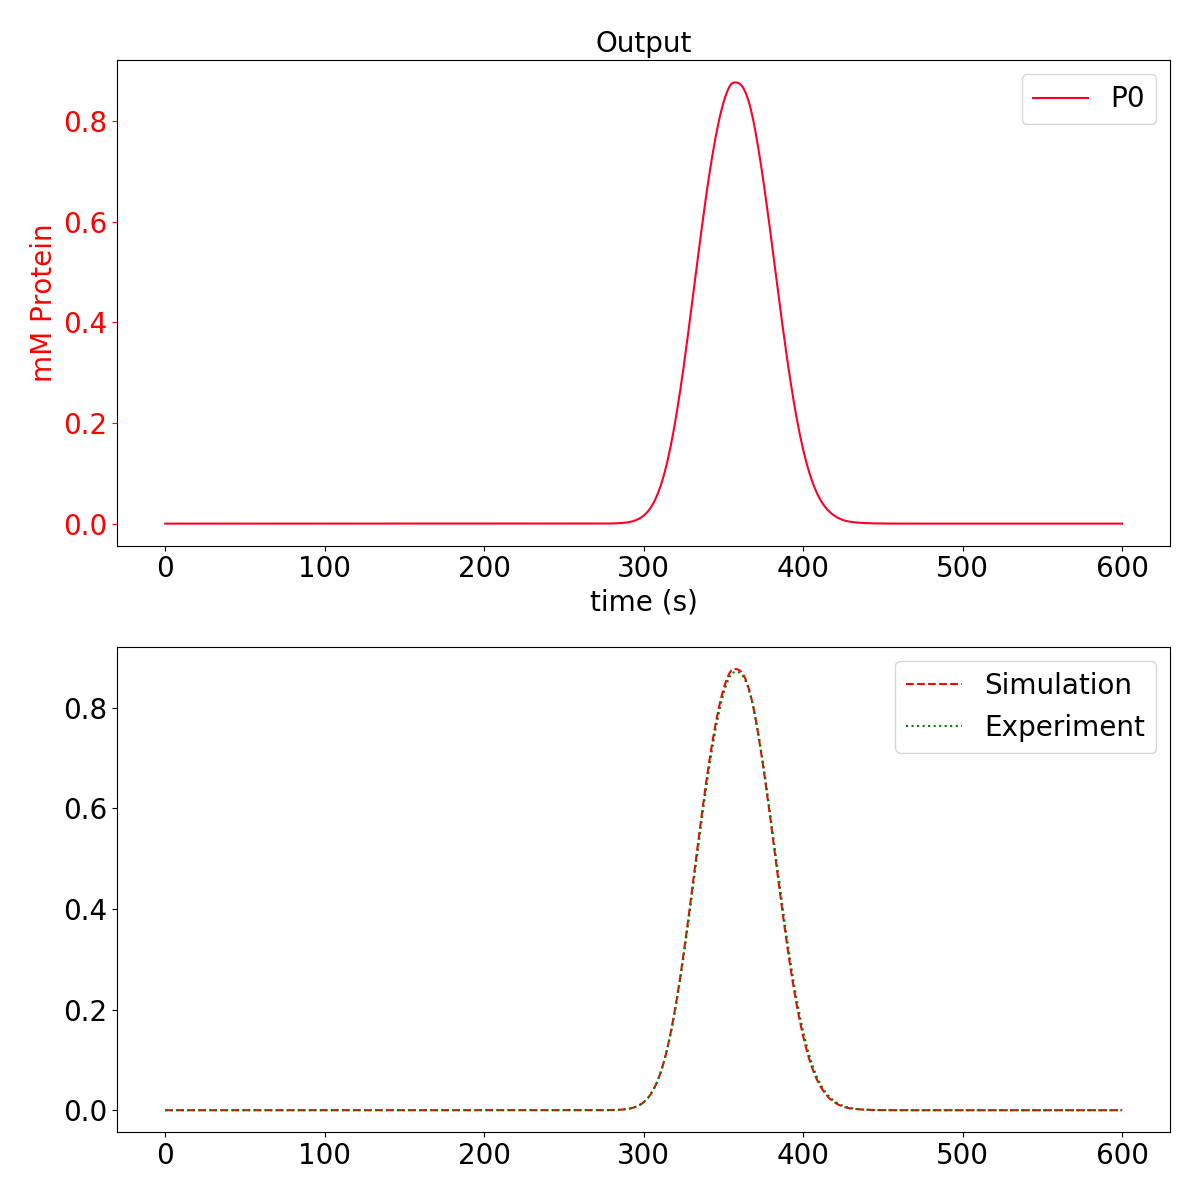

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07  true_value = 2.00e-07 error: 0.47%
COL_POROSITY Comp:-1 Bound:-1 = 3.66e-01  true_value = 3.70e-01 error: 1%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07  true_value = 2.00e-07 error: 0.47%
COL_POROSITY Comp:-1 Bound:-1 = 3.66e-01  true_value = 3.70e-01 error: 1%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07  true_value = 2.00e-07 error: 0.47%
COL_POROSITY Comp:-1 Bound:-1 = 3.66e-01  true_value = 3.70e-01 error: 1%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07  true_value = 2.00e-07 error: 0.47%
COL_POROSITY Comp:-1 Bound:-1 = 3.66e-01  true_value = 3.70e-01 error: 1%




In [10]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity,])
    
sim_non = run_match(match,
                    match_file,
                    true_values,
                    delete=True)

## View results

# Create Dextran experiment

## Create configuration file

## Run match

## View results